<h3 align="center">DS-301 HW3</h3> 
<h3 align="center">Grace Yang</h3> 
<h3 align="center">gy654, N10610063</h3> 

## Problem 1 - Learning Rate, Batch Size, FashionMNIST 20 points
Recall cyclical learning rate policy discussed in Lecture 4. The learning rate changes in cyclical manner between $lr_{min}$ and $lr_{max}$, which are hyperparameters that need to be specified. For this problem you first need to read carefully the article referenced below as you will be making use of the code there (in Keras) and modifying it as needed. For those who want to work in Pytorch there are open source implementations of this policy available which you can easily search for and build over them. You will work with FashionMNIST dataset and LeNet-5.

1. Fix batch size to 64 and start with 10 candidate learning rates between $10^{−9}$ and $10^{1}$ and train your model for 5 epochs. Plot the training loss as a function of learning rate. You should see a curve like Figure 3 in reference below. From that figure identify the values of $lr_{min}$ and $lr_{max}$.

In [ ]:
# import the necessary packages
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import keras
from keras import layers
import tensorflow as tf

%matplotlib inline


In [ ]:
class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta
		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []
		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None



	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "DataFrameIterator", "Iterator", "Sequence"]
		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)
		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)
		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss
		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return
		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth
		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=64, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()
		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)
		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)
		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))
		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
    
    # compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch
		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)
		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)
		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))
		# check to see if we are using a data iterator
		if useGen:
			self.model.fit(
				x=trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])
		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				x=trainData[0], y=trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)
		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)
  

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]
		print('start plotting')
		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")
		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)
		plt.show()

In [ ]:
class config: 
  # import the necessary packages
  import os
  # initialize the list of class label names
  CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']
  # define the minimum learning rate, maximum learning rate, batch size,
  # step size, CLR method, and number of epochs
  MIN_LR = 1e-9
  MAX_LR = 10
  BATCH_SIZE = 64
  STEP_SIZE = 1
  CLR_METHOD = "exp_range"
  NUM_EPOCHS = 5


In [ ]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys
from keras.metrics import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, AveragePooling2D, Dropout, Normalization
from tensorflow.keras.callbacks import *

In [ ]:

ap = argparse.ArgumentParser()
ap.add_argument("-f", "--lr-find", type=int, default=0,
	help="whether or not to find optimal learning rate")
# set arg to 1(not to find optimal learning rate)
args = vars(ap.parse_args(args=["--lr-find",'1']))
# args = ap.parse_args()
print(args)

{'lr_find': 1}


In [ ]:
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1)) # 60000, 32,32,1
testX = testX.reshape((testX.shape[0], 32, 32, 1))

[INFO] loading Fashion MNIST data...
4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

In [ ]:

def LeNet():
  model = Sequential()
  model.add(Conv2D(6, 5, activation='relu', input_shape=(32,32,1)))
  model.add(AveragePooling2D(2))
  model.add(Conv2D(16, 5, activation='relu'))
  model.add(AveragePooling2D(2))
  model.add(Dense(120, activation='relu'))
  model.add(Flatten())
  model.add(Dense(84, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss = categorical_crossentropy, 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])      
  return model

[INFO] finding learning rate...
Epoch 1/5
938/938 [==============================] - 58s 61ms/step - loss: 2.3037 - accuracy: 0.1074
Epoch 2/5
938/938 [==============================] - 56s 60ms/step - loss: 2.2970 - accuracy: 0.1060
Epoch 3/5
938/938 [==============================] - 57s 61ms/step - loss: 1.1898 - accuracy: 0.5901
Epoch 4/5
938/938 [==============================] - 56s 59ms/step - loss: 0.7888 - accuracy: 0.7032
Epoch 5/5
938/938 [==============================] - 56s 59ms/step - loss: 2.7857 - accuracy: 0.1517
start plotting


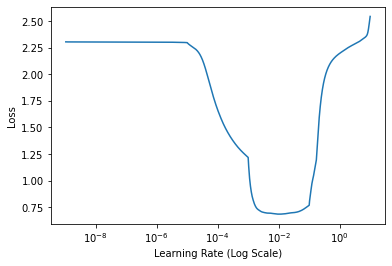

In [ ]:
model = LeNet()
# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs
if args["lr_find"] > 0:
	# initialize the learning rate finder and then train with learning
	# rates ranging from 1e-10 to 1e+1
	print("[INFO] finding learning rate...")
	lrf = LearningRateFinder(model)
	lrf.find(
		aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE), 1e-9, 1e+1, epochs=5,
		stepsPerEpoch=np.ceil((len(trainX) / float(config.BATCH_SIZE))),
		batchSize=config.BATCH_SIZE)
	lrf.plot_loss()

$lr_{min} = 1e-5 , lr_{max} =1e-2$. 

When lr < 1e-5, the network is unable to learn. lr of 1e-5 is just large enough for network to start learning. When lr = 1e-2, there is a small increase in loss, which is a sign that lr starts to become too large. The exploding loss suggests that lr>1e-2 is way too large.

2. Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and $lr_{min}$ and $lr_{max}$ values obtained in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference).

`https://github.com/bckenstler/CLR/blob/master/clr_callback.py`

exp range: the learning rate varies between the minimum and maximum boundaries and each boundary value declines by an exponential factor of gammaiteration.

In [ ]:

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
model_clr = LeNet()
steps_per_epoch = len(trainX) // config.BATCH_SIZE
# set bounds of appropriate lr obtained in part 1
clr = CyclicLR(base_lr = 1e-5, 
               max_lr = 1e-2, 
               step_size = steps_per_epoch,
               mode = config.CLR_METHOD, 
               gamma = 0.99)
clr_history = model_clr.fit(x = trainX, 
                        y = trainY, 
                        batch_size = config.BATCH_SIZE,
                        epochs= config.NUM_EPOCHS,
                        callbacks = [clr],
                        validation_data = (testX, testY),
                        validation_steps = 100)

Epoch 1/5
938/938 [==============================] - 18s 9ms/step - loss: 0.7415 - accuracy: 0.7284 - val_loss: 0.6223 - val_accuracy: 0.7755
Epoch 2/5
938/938 [==============================] - 9s 10ms/step - loss: 0.5881 - accuracy: 0.7832 - val_loss: 0.6112 - val_accuracy: 0.7773
Epoch 3/5
938/938 [==============================] - 10s 11ms/step - loss: 0.5774 - accuracy: 0.7874 - val_loss: 0.6026 - val_accuracy: 0.7827
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.5676 - accuracy: 0.7916 - val_loss: 0.5952 - val_accuracy: 0.7842
Epoch 5/5
938/938 [==============================] - 5s 6ms/step - loss: 0.5589 - accuracy: 0.7944 - val_loss: 0.5862 - val_accuracy: 0.7862


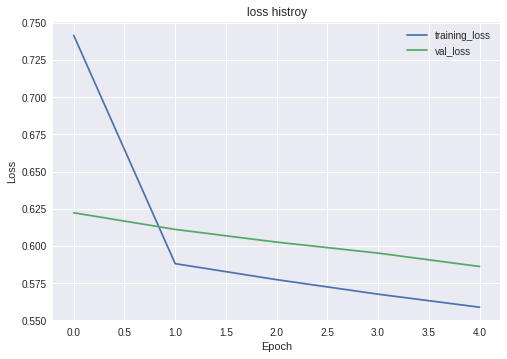

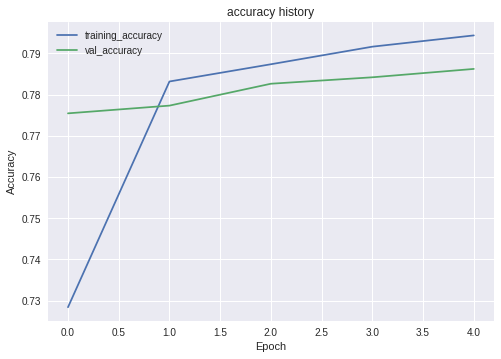

In [ ]:
plt.style.use("seaborn")
plt.plot(clr_history.history['loss'], label='training_loss')
plt.plot(clr_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss histroy')
plt.legend(loc = 'best')
plt.show()

plt.plot(clr_history.history['accuracy'], label = 'training_accuracy')
plt.plot(clr_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy history')
plt.legend(loc='best')


3. We want to test if increasing batch size for a fixed learning rate has the same effect as decreasing learning rate for a fixed batch size. Fix learning rate to lrmax and train your network starting with batch size 32 and incrementally going upto 4096 (in increments of a factor of 2; like 32, 64...). You can choose a step size (in terms of number of iterations) to increment the batch size. Plot the training loss. Is the generalization of your final model similar or different than cyclical learning rate policy? 


In [ ]:

def LeNet_fix_lr():
  model = Sequential()
  model.add(Conv2D(6, 5, activation='relu', input_shape=(32,32,1)))
  model.add(AveragePooling2D(2))
  model.add(Conv2D(16, 5, activation='relu'))
  model.add(AveragePooling2D(2))
  model.add(Dense(120, activation='relu'))
  model.add(Flatten())
  model.add(Dense(84, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss = categorical_crossentropy, 
                optimizer = tf.keras.optimizers.Adam(lr = 1e-2), 
                metrics = ['accuracy'])      
  return model

In [ ]:
batches = [32,64,128,256,512,1024,2048,4096]
# one batch size per ecpoch
model = LeNet_fix_lr()
loss_list, val_loss_list , acc_list, val_acc_list= [], [], [], []
for batch in batches:
  # continue training the same model
  batch_history = model.fit(x = trainX, 
                        y = trainY, 
                        batch_size = batch,
                        epochs=1,
                        validation_data = (testX, testY),
                        validation_steps = 100)
  loss_list.append(batch_history.history['loss'][-1])
  val_loss_list.append(batch_history.history['val_loss'][-1])
  acc_list.append(batch_history.history['accuracy'][-1])
  val_acc_list.append(batch_history.history['val_accuracy'][-1])

 

469/469 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8917

229/235 [============================>.] - ETA: 0s - loss: 0.2583 - accuracy: 0.9024

114/118 [===========================>..] - ETA: 0s - loss: 0.2364 - accuracy: 0.9113

59/59 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9159

28/30 [===========================>..] - ETA: 0s - loss: 0.2107 - accuracy: 0.9205

15/15 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9219

15/15 [==============================] - 1s 69ms/step - loss: 0.2060 - accuracy: 0.9219 - val_loss: 0.2848 - val_accuracy: 0.8999


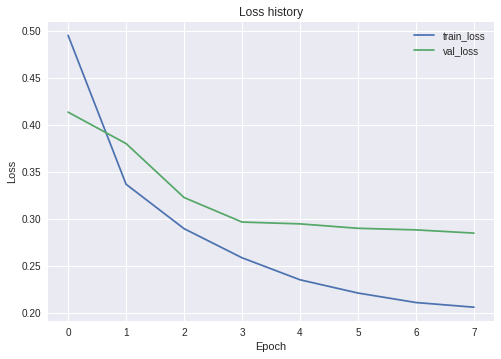

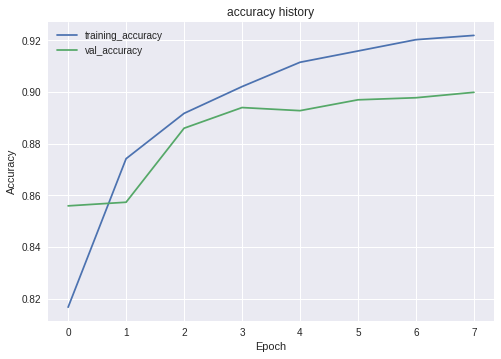

In [ ]:
plt.style.use("seaborn")
plt.plot(loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(loc='best')
plt.show()
plt.plot(acc_list, label = 'training_accuracy')
plt.plot(val_acc_list, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy history')
plt.legend(loc='best')

The generalization of your final model using increasing batch size during training is not similar to the cyclical learning rate policy. Using fixed lr_max with increasing batch size has slighly better performance, achieving 0.89 accuracy at the end. However, this may be due to two extra training epochs compared with training 5 epochs in part b. 

#Problem 2 - Convolutional Neural Networks Architectures 35 points
In this problem we will study and compare different convolutional neural network architectures. We will calculate number of parameters (weights, to be learned) and memory requirement of each network. We will also analyze inception modules and understand their design.

1. Calculate the number of parameters in Alexnet. You will have to show calculations for each layer and then sum it to obtain the total number of parameters in Alexnet. When calculating you will need to account for all the filters (size, strides, padding) at each layer. Look at Sec. 3.5 and Figure 2 in Alexnet paper (see reference). Points will only be given when explicit calculations are shown for each layer. (4)

| Layer   | Number of feature map |size | kernel size | stride| pad| number of parameters calculation|total parameters|
| ---------------- | --------------- |--------------- |--------------- |--------------- |--------------- |--------------- |--------------- |
|input|1|227\*227\*3|-|-|-|-|-|
|CONV1|96|55\*55\*96|11\*11|4|0|11\*11\*3\*96+96|34944
|MAX POOL1|96|27\*27\*96|3\*3|2|0|0|0
|CONV2|256|27\*27\*256|5\*5|1|2|5\*5\*96\*256+256|614656
|MAX POOL2|256|13\*13\*256|3\*3|2|0|0|0
|CONV3|384|13\*13\*384|3\*3|1|1|3\*3\*256\*384+384|885120
|CONV4|384|13\*13\*384|3\*3|1|1|3\*3\*384\*384+384|1327488
|CONV5|256|13\*13\*256|3\*3|1|1|3\*3\*384\*256+256|884992
|MAX POOL3|256|6\*6\*256|3\*3|2|0|0|0
|FC1|-|4096|-|-|-|6\*6\*256\*4096+4096|37752832
|FC2|-|4096|-|-|-|4096\*4096+4096|16781312
|FC3|-|1000|-|-|-|4096\*1000+1000|4097000


2. VGG (Simonyan et al.) has an extremely homogeneous architecture that only performs 3x3 convolutions with stride 1 and pad 1 and 2x2 max pooling with stride 2 (and no padding) from the beginning to the end. However VGGNet is very expensive to evaluate and uses a lot more memory and parameters. Refer to VGG19 architecture on page 3 in Table 1 of the paper by Simonyan et al. You need to complete Table 1 below for calculating activation units and parameters at each layer in VGG19 (without counting biases). Its been partially filled for you. 

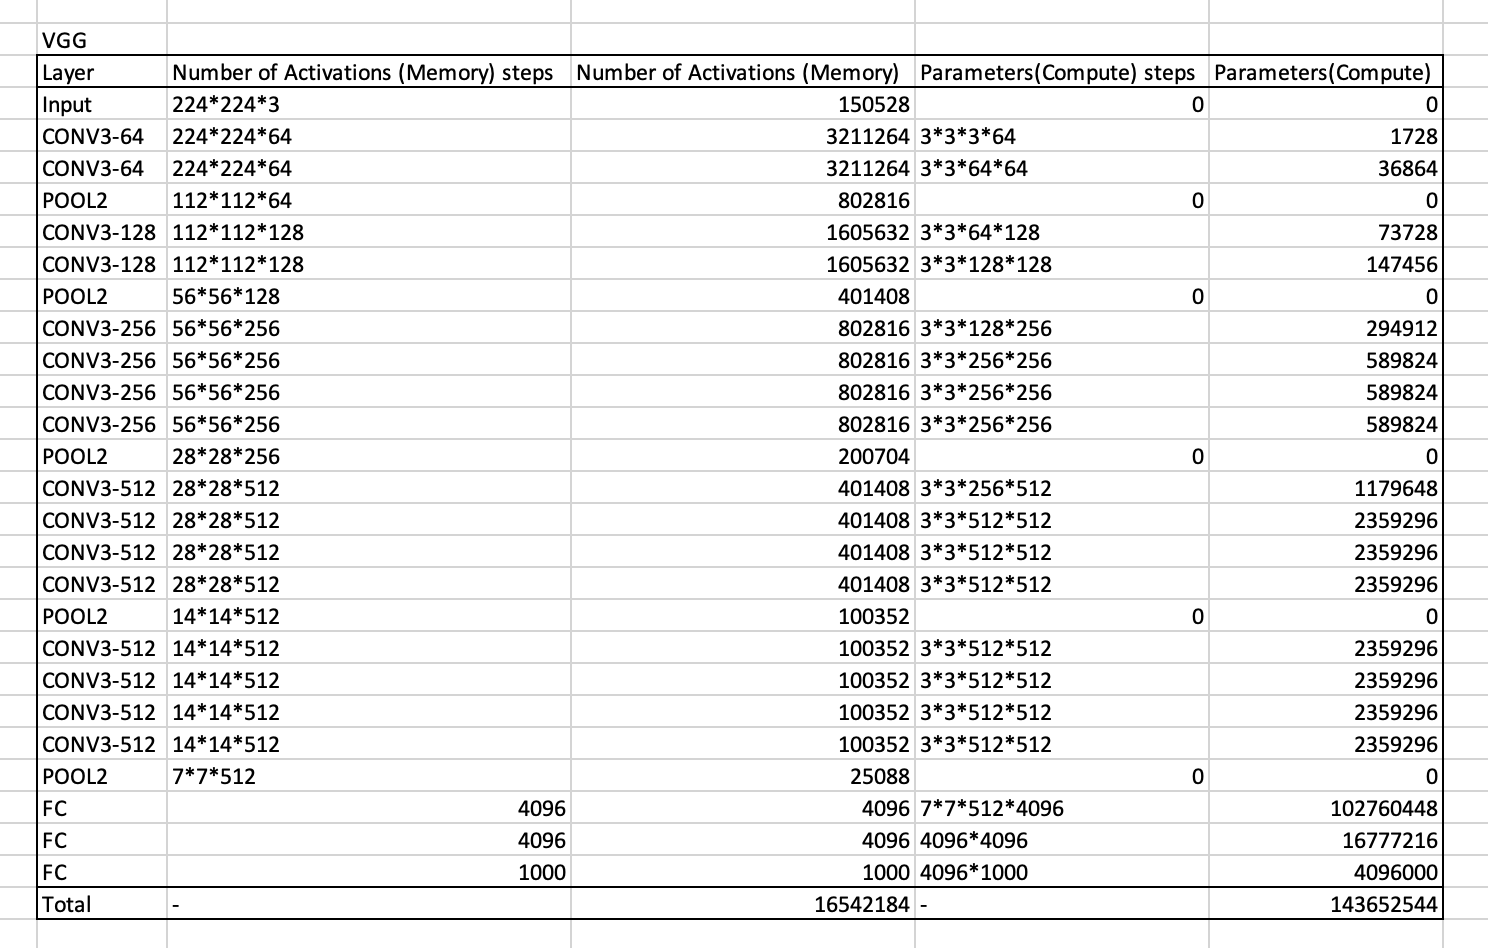

3. VGG architectures have smaller filters but deeper networks compared to Alexnet (3x3 compared to 11x11 or 5x5). Show that a stack of $N$ convolution layers each of filter size $F × F$ has the same receptive field as one convolution layer with filter of size $(NF − N + 1) × (NF − N + 1)$. Use this to calculate the receptive field of 3 filters of size 5x5. 

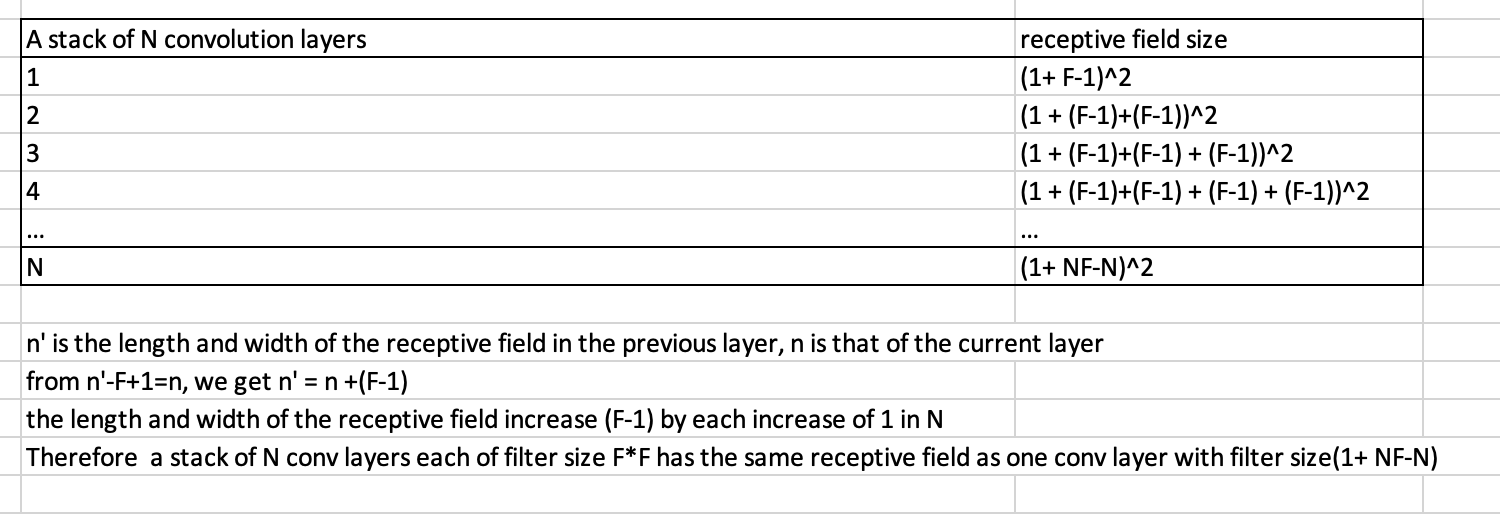

4. The original Googlenet paper (Szegedy et al.) proposes two architectures for Inception module, shown in Figure 2 on page 5 of the paper, referred to as naive and dimensionality reduction respectively.

(a) What is the general idea behind designing an inception module (parallel convolutional filters of different sizes with a pooling followed by concatenation) in a convolutional neural network ? (2)


The inception module is a carefully crafted design that allows for increasing the depth and width of the network while keeping the computational budget constant. It provides evidence that moving to sparser architectures is feasible and useful idea in general.

(b). Assuming the input to inception module (referred to as ”previous layer” in Figure 2 of the pa- per) has size 32x32x256, calculate the output size after filter concatenation for the naive and dimensionality reduction inception architectures with number of filters given in Figure 1.

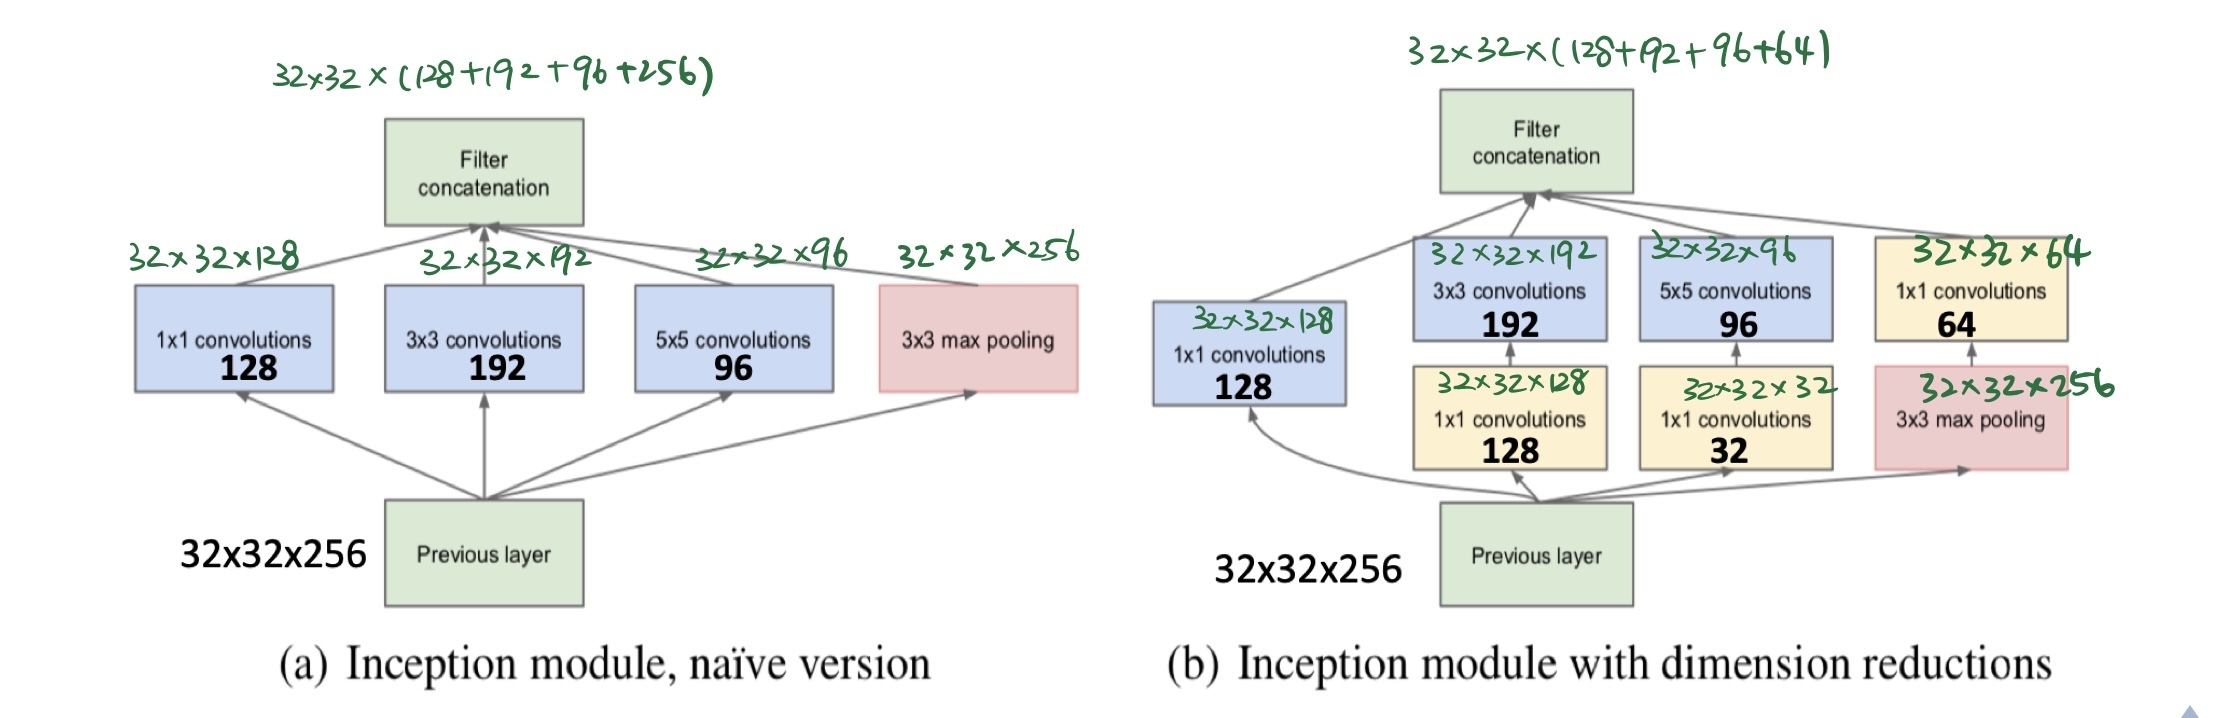

(c). Next calculate the total number of convolutional operations for each of the two inception archi- tecture again assuming the input to the module has dimensions 32x32x256 and number of filters given in Figure 1.

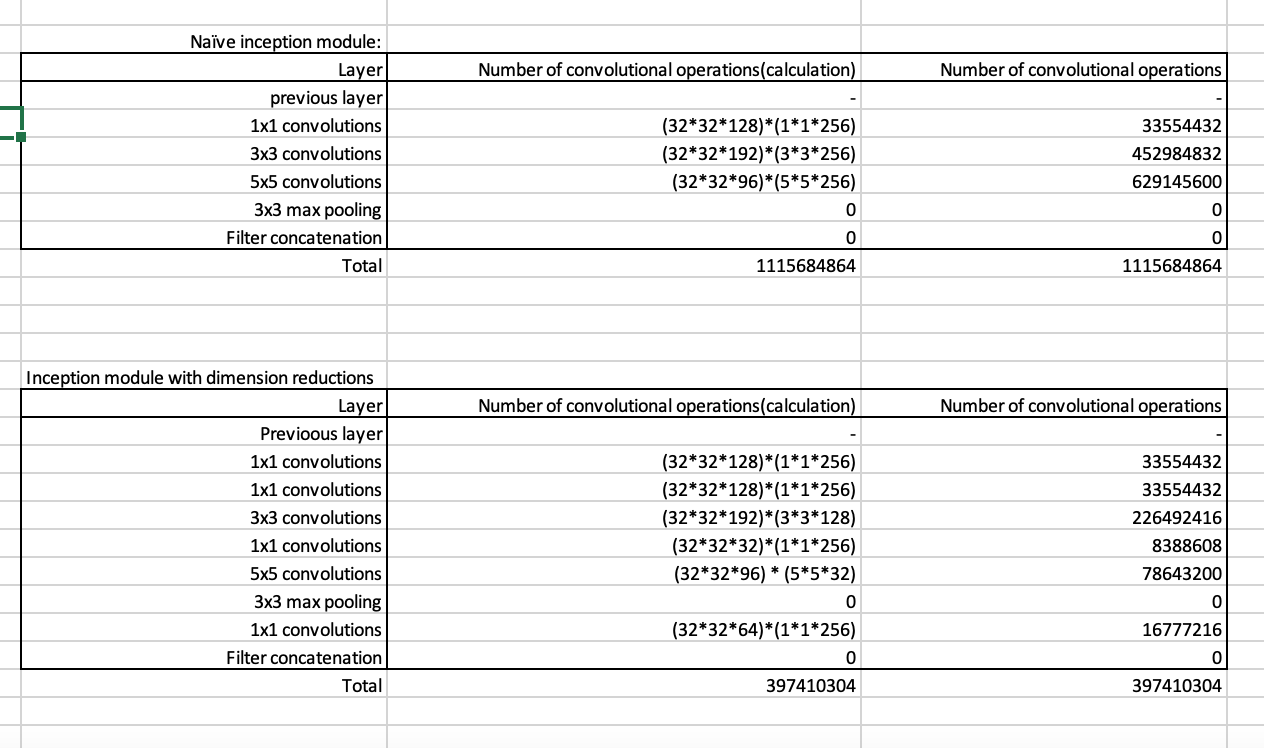

(d) Based on the calculations in part (c) explain the problem with naive architecture and how dimensionality reduction architecture helps (Hint: compare computational complexity). How much is the computational saving ?

The total number of convolutional operations(computational complexity) of the naive version is more than three times of that of the dimensional reduction version. The dimensional reduction design saves computational savings while increasing the depth of the network.

5. Faster-RCNN is a CNN based architecture for object detection which is much faster that Fast-RCNN. Read about Faster-RCNN in Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks and answer the following questions:

(a)What is the main difference between Fast-RCNN and Faster-RCNN that resulted in faster detection using Faster-RCNN?

Faster R-CNN, is composed of two modules. The first module is a deep fully convolutional network that proposes regions, and the second module is the Fast R-CNN detector that uses the proposed regions. Compared to Fast-RCNN, it adds a deep fully convolutional network. 

(b). What is Region Proposal Network (RPN)? Clearly explain its architecture.

A Region Proposal Network (RPN) takes an image (of any size) as input and outputs a set of rectangular object proposals, each with an objectness score.

To generate region proposals, we slide a small network over the convolutional feature map output by the last shared convolutional layer. This small network takes as input an n × n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature. This feature is fed into two sibling fullyconnected layers—a box-regression layer (reg) and a box-classification layer (cls).

(c) Explain how are region proposals generated from RPN using an example image.

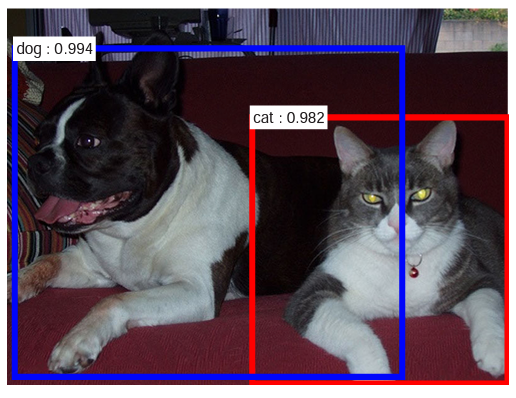



To generate region proposals, we slide a small network over the convolutional feature map output by the last shared convolutional layer. This small network takes as input an n × n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature. This feature is fed into two sibling fullyconnected layers—a box-regression layer (reg) to predict the rectangular anchor boxes for the cat object and the dog object and a box-classification layer (cls) to generate the prediction scores of cat (0.982)and dog(0.994). 

As the sliding window slides through fearture map, RPN proposes a dog object with socre 0.994 within the blue anchor box and a cat with socre 0.982 within the red anchor box. 


(d) There is a lot of overlap in the region proposals generated by RPN. What technique is used in Faster-RCNN to reduce the number of proposals to roughly 2000? Explain how does this technique work using an example.

Some RPN proposals highly overlap with each other. To reduce redundancy, researchers adopt non-maximum suppression(NMS) on the proposal regions based on their cls scores. They fix the IoU threshold for NMS at 0.7,which leaves us about 2000 proposal regions per image. NMS does not harm the ultimate detection accuracy,but substantially reduces the number of proposals.

In the above example, there is an overlap between the detected cat and the detected dog. If we fix the IoU threshold at 0.99, this will leave us only with the dog but not the cat because the cls score for the dog is 0.994(>0.99), but the cls score for the cat is 0.982(< 0.99).

## Problem 3 - Transfer learning: Shallow learning vs Finetuning, Pytorch 25 points

In this problem we will train a convolutional neural network for image classification using transfer learning. Transfer learning involves training a base network from scratch on a very large dataset (e.g., Imagenet1K with 1.2 M images and 1K categories) and then using this base network either as a feature extractor or as an initialization network for target task. Thus two major transfer learning scenarios are as follows:

- Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however the learning rate schedule for transfer learning may be different.
- Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

1. For fine-tuning you will select a target dataset from the Visual-Decathlon challenge. Their web site (link below) has several datasets which you can download. Select any one of the visual decathlon dataset and make it your target dataset for transfer learning. Important : Do not select Imagenet1K as the target dataset.

(a) Finetuning: You will first load a pretrained model (Resnet50) and change the final fully connected layer output to the number of classes in the target dataset. Describe your target dataset features, number of classes and distribution of images per class (i.e., number of images per class). Show any 4 sample images (belonging to 2 different classes) from your target dataset. (2+2)

Target Dataset Descriptions:

Data based on "German Traffic Signs", with images resized isotropically to have a shorter size of 72 pixels

|Dataset| E base|number of classes|training|validation|testing|
|--------------- |--------------- |--------------- |--------------- |--------------- |--------------- |
|GTSRB|2.47|43|31367|7842|12630|

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! tar -xvf /content/drive/MyDrive/ds301HW/gtsrb.tar 

Streaming output truncated to the last 5000 lines.
gtsrb/train/0004/000914.jpg
gtsrb/train/0004/001388.jpg
gtsrb/train/0004/000867.jpg
gtsrb/train/0004/001164.jpg
gtsrb/train/0004/001104.jpg
gtsrb/train/0004/001197.jpg
gtsrb/train/0004/000493.jpg
gtsrb/train/0004/001231.jpg
gtsrb/train/0004/000612.jpg
gtsrb/train/0004/000422.jpg
gtsrb/train/0004/000298.jpg
gtsrb/train/0004/000891.jpg
gtsrb/train/0004/000827.jpg
gtsrb/train/0004/000981.jpg
gtsrb/train/0004/001032.jpg
gtsrb/train/0004/000384.jpg
gtsrb/train/0004/000730.jpg
gtsrb/train/0004/000089.jpg
gtsrb/train/0004/000627.jpg
gtsrb/train/0004/000926.jpg
gtsrb/train/0004/000173.jpg
gtsrb/train/0004/000255.jpg
gtsrb/train/0004/000986.jpg
gtsrb/train/0004/000347.jpg
gtsrb/train/0004/001048.jpg
gtsrb/train/0004/000752.jpg
gtsrb/train/0004/000224.jpg
gtsrb/train/0004/000488.jpg
gtsrb/train/0004/000814.jpg
gtsrb/train/0004/000702.jpg
gtsrb/train/0004/000547.jpg
gtsrb/train/0004/000535.jpg
gtsrb/train/0004/000559.jpg
gtsrb/train/0004/000428.j

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


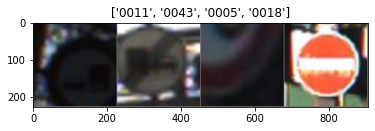

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gtsrb'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
from collections import Counter
def label_dist(mode):
  classes = image_datasets[mode].classes
  label_dist = [label for pic, label in image_datasets[mode]]
  counts = Counter(label_dist)
  print(f'{mode} label distribution:{counts}')
  return counts
train_counter = label_dist('train')
val_counter = label_dist('val')


train label distribution:Counter({2: 1800, 1: 1776, 13: 1728, 12: 1680, 38: 1656, 10: 1608, 4: 1584, 5: 1488, 25: 1200, 9: 1176, 7: 1152, 3: 1128, 8: 1128, 11: 1056, 18: 960, 35: 960, 17: 888, 14: 624, 31: 624, 33: 551, 15: 504, 26: 480, 28: 432, 23: 408, 30: 360, 6: 336, 16: 336, 34: 336, 22: 312, 36: 312, 20: 288, 40: 288, 21: 264, 39: 240, 24: 216, 29: 216, 27: 192, 32: 192, 41: 192, 42: 192, 0: 168, 19: 168, 37: 168})
val label distribution:Counter({2: 450, 1: 444, 13: 432, 12: 420, 38: 414, 10: 402, 4: 396, 5: 372, 25: 300, 9: 294, 7: 288, 3: 282, 8: 282, 11: 264, 18: 240, 35: 240, 17: 222, 14: 156, 31: 156, 33: 138, 15: 126, 26: 120, 28: 108, 23: 102, 30: 90, 6: 84, 16: 84, 34: 84, 22: 78, 36: 78, 20: 72, 40: 72, 21: 66, 39: 60, 24: 54, 29: 54, 27: 48, 32: 48, 41: 48, 42: 48, 0: 42, 19: 42, 37: 42})


Text(0.5, 1.0, 'Validation sample class distribution')

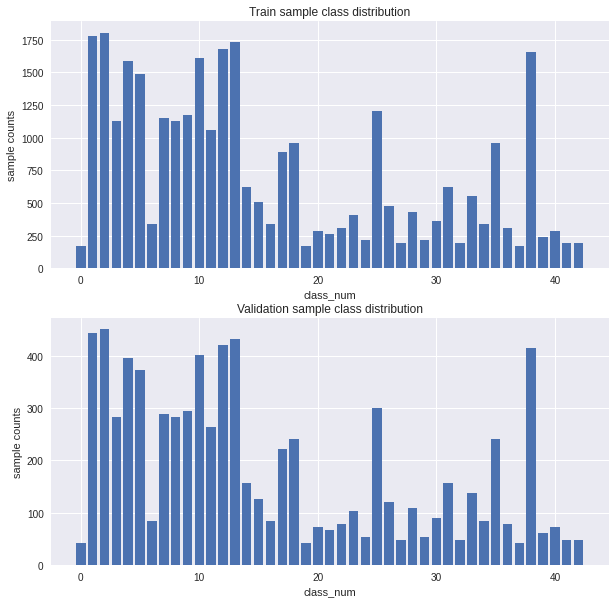

In [ ]:
plt.style.use('seaborn')
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].bar(train_counter.keys(), train_counter.values())
axs[0].set_xlabel('class_num')
axs[0].set_ylabel('sample counts')
axs[0].set_title('Train sample class distribution')

axs[1].bar(val_counter.keys(),val_counter.values())
axs[1].set_xlabel('class_num')
axs[1].set_ylabel('sample counts')
axs[1].set_title('Validation sample class distribution')

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


(b) First finetune by setting the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers. Keep batch size of 64 and train for 200-300 epochs or until model converges well. You will use a multi-step learning rate schedule and decay by a factor of 0.1 (γ = 0.1 in the link below). You can choose steps at which you want to decay the learning rate but do 3 drops during the training. So the first drop will bring down the learning rate to 0.0001, second to 0.00001, third to 0.000001. For example, if training for 200 epochs, first drop can happen at epoch 60, second at epoch 120 and third at epoch 180.


Epoch 0/9
----------
train Loss: 1.5743 Acc: 0.5888
val Loss: 0.3170 Acc: 0.9216

Epoch 1/9
----------
train Loss: 0.4583 Acc: 0.8683
val Loss: 0.1311 Acc: 0.9652

Epoch 2/9
----------
train Loss: 0.3164 Acc: 0.9046
val Loss: 0.0704 Acc: 0.9823

Epoch 3/9
----------
train Loss: 0.2628 Acc: 0.9225
val Loss: 0.0529 Acc: 0.9846

Epoch 4/9
----------
train Loss: 0.2482 Acc: 0.9256
val Loss: 0.0511 Acc: 0.9874

Epoch 5/9
----------
train Loss: 0.2396 Acc: 0.9276
val Loss: 0.0473 Acc: 0.9879

Epoch 6/9
----------
train Loss: 0.2347 Acc: 0.9296
val Loss: 0.0464 Acc: 0.9889

Epoch 7/9
----------
train Loss: 0.2326 Acc: 0.9303
val Loss: 0.0476 Acc: 0.9885

Epoch 8/9
----------
train Loss: 0.2337 Acc: 0.9302
val Loss: 0.0482 Acc: 0.9875

Epoch 9/9
----------
train Loss: 0.2325 Acc: 0.9295
val Loss: 0.0470 Acc: 0.9878

Training complete in 58m 7s
Best val Acc: 0.988906


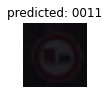

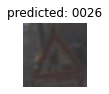

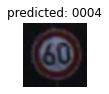

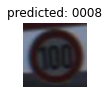

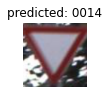

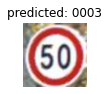

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
# 10 epochs are enough for the model to converge well
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
visualize_model(model_ft)


(c) Next keeping all the hyperparameters (including multi-step learning rate schedule) same as before, change the learning rate to 0.01 and 0.1 uniformly for all the layers. This means keep all the layers at same learning rate. So you will be doing two experiments, one keeping learning rate of all layers at 0.01 and one with 0.1. Again finetune the model and report the final accuracy. How does the accuracy with the three learning rates compare ? Which learning rate gives you the best accuracy on the target dataset ?

Constant lr: 0.01

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6996 Acc: 0.7954
val Loss: 0.0967 Acc: 0.9674

Epoch 1/9
----------
train Loss: 0.2933 Acc: 0.9069
val Loss: 0.0379 Acc: 0.9889

Epoch 2/9
----------
train Loss: 0.2449 Acc: 0.9210
val Loss: 0.0461 Acc: 0.9842

Epoch 3/9
----------
train Loss: 0.2148 Acc: 0.9302
val Loss: 0.0291 Acc: 0.9897

Epoch 4/9
----------
train Loss: 0.1932 Acc: 0.9369
val Loss: 0.0152 Acc: 0.9964

Epoch 5/9
----------
train Loss: 0.1844 Acc: 0.9392
val Loss: 0.0193 Acc: 0.9945

Epoch 6/9
----------
train Loss: 0.1721 Acc: 0.9435
val Loss: 0.0119 Acc: 0.9969

Epoch 7/9
----------
train Loss: 0.1648 Acc: 0.9473
val Loss: 0.0204 Acc: 0.9934

Epoch 8/9
----------
train Loss: 0.1539 Acc: 0.9508
val Loss: 0.0222 Acc: 0.9939

Epoch 9/9
----------
train Loss: 0.1505 Acc: 0.9515
val Loss: 0.0143 Acc: 0.9960

Training complete in 57m 57s
Best val Acc: 0.996940


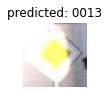

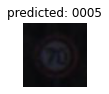

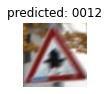

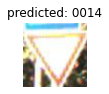

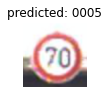

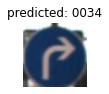

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
# constant LR by setting gamma = 1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=1)
# 10 epochs are enough for the model to converge well
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
visualize_model(model_ft)


Constant lr: 0.1

Epoch 0/9
----------
train Loss: 3.4135 Acc: 0.1081
val Loss: 3.5156 Acc: 0.0976

Epoch 1/9
----------
train Loss: 2.6261 Acc: 0.2354
val Loss: 1.9243 Acc: 0.3837

Epoch 2/9
----------
train Loss: 1.7281 Acc: 0.4567
val Loss: 0.8022 Acc: 0.7358

Epoch 3/9
----------
train Loss: 0.9310 Acc: 0.7103
val Loss: 0.5678 Acc: 0.8147

Epoch 4/9
----------
train Loss: 0.5909 Acc: 0.8157
val Loss: 0.3401 Acc: 0.8901

Epoch 5/9
----------
train Loss: 0.4731 Acc: 0.8508
val Loss: 0.1333 Acc: 0.9538

Epoch 6/9
----------
train Loss: 0.4026 Acc: 0.8723
val Loss: 0.1509 Acc: 0.9536

Epoch 7/9
----------
train Loss: 0.3557 Acc: 0.8867
val Loss: 0.1416 Acc: 0.9518

Epoch 8/9
----------
train Loss: 0.3306 Acc: 0.8962
val Loss: 0.0778 Acc: 0.9754

Epoch 9/9
----------
train Loss: 0.2960 Acc: 0.9057
val Loss: 0.0705 Acc: 0.9756

Training complete in 57m 28s
Best val Acc: 0.975644


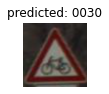

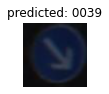

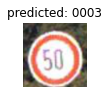

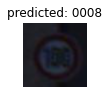

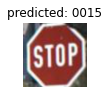

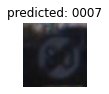

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)
# constant LR by setting gamma = 1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=1)
# 10 epochs are enough for the model to converge well
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

visualize_model(model_ft)


2. When using a pretrained model as feature extractor, all the layers of the network are frozen except the final layer. Thus except the last layer, none of the inner layers’ gradients are updated during backward pass with the target dataset. Since gradients do not need to be computed for most of the network, this is faster than finetuning.


(a) Now train only the last layer for 1, 0.1, 0.01, and 0.001 while keeping all the other hyperparameters and settings same as earlier for finetuning. Which learning rate gives you the best accuracy on the target dataset? 


----------Experiment for constant lr:1 starts!-----------
Epoch 0/9
----------
train Loss: 105.4523 Acc: 0.3743
val Loss: 41.9023 Acc: 0.5362

Epoch 1/9
----------
train Loss: 45.0506 Acc: 0.4649
val Loss: 48.6073 Acc: 0.4795

Epoch 2/9
----------
train Loss: 45.3587 Acc: 0.4929
val Loss: 30.6373 Acc: 0.6094

Epoch 3/9
----------
train Loss: 42.4831 Acc: 0.5058
val Loss: 22.4372 Acc: 0.6452

Epoch 4/9
----------
train Loss: 38.9422 Acc: 0.5249
val Loss: 63.7958 Acc: 0.4927

Epoch 5/9
----------
train Loss: 40.0187 Acc: 0.5302
val Loss: 37.5018 Acc: 0.5895

Epoch 6/9
----------
train Loss: 40.9914 Acc: 0.5343
val Loss: 33.8921 Acc: 0.6201

Epoch 7/9
----------
train Loss: 38.4007 Acc: 0.5443
val Loss: 22.7110 Acc: 0.6714

Epoch 8/9
----------
train Loss: 38.2674 Acc: 0.5530
val Loss: 25.9135 Acc: 0.6695

Epoch 9/9
----------
train Loss: 39.8784 Acc: 0.5498
val Loss: 27.0200 Acc: 0.6835

Training complete in 22m 28s
Best val Acc: 0.683499


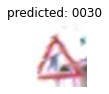

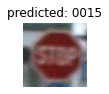

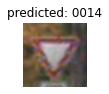

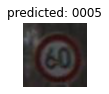

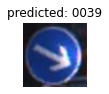

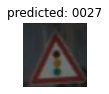

--------Experiment for constant lr:1 ends!------------
----------Experiment for constant lr:0.1 starts!-----------
Epoch 0/9
----------
train Loss: 5.1635 Acc: 0.3904
val Loss: 2.4388 Acc: 0.6023

Epoch 1/9
----------
train Loss: 4.1353 Acc: 0.4771
val Loss: 4.7657 Acc: 0.5395

Epoch 2/9
----------
train Loss: 3.8722 Acc: 0.5112
val Loss: 3.4104 Acc: 0.5830

Epoch 3/9
----------
train Loss: 3.6715 Acc: 0.5276
val Loss: 2.7932 Acc: 0.6123

Epoch 4/9
----------
train Loss: 3.5831 Acc: 0.5342
val Loss: 3.1746 Acc: 0.6218

Epoch 5/9
----------
train Loss: 3.7162 Acc: 0.5415
val Loss: 3.0631 Acc: 0.6190

Epoch 6/9
----------
train Loss: 3.5020 Acc: 0.5558
val Loss: 2.9629 Acc: 0.6367

Epoch 7/9
----------
train Loss: 3.4967 Acc: 0.5597
val Loss: 2.8136 Acc: 0.6558

Epoch 8/9
----------
train Loss: 3.4407 Acc: 0.5681
val Loss: 3.2662 Acc: 0.6310

Epoch 9/9
----------
train Loss: 3.4170 Acc: 0.5683
val Loss: 2.2741 Acc: 0.6556

Training complete in 23m 1s
Best val Acc: 0.655828


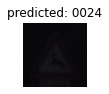

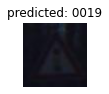

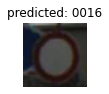

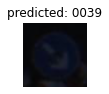

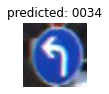

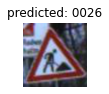

--------Experiment for constant lr:0.1 ends!------------
----------Experiment for constant lr:0.01 starts!-----------
Epoch 0/9
----------
train Loss: 2.0220 Acc: 0.4346
val Loss: 1.2497 Acc: 0.6157

Epoch 1/9
----------
train Loss: 1.5369 Acc: 0.5461
val Loss: 1.0562 Acc: 0.6695

Epoch 2/9
----------
train Loss: 1.4360 Acc: 0.5694
val Loss: 0.9963 Acc: 0.6741

Epoch 3/9
----------
train Loss: 1.3639 Acc: 0.5906
val Loss: 0.9251 Acc: 0.7068

Epoch 4/9
----------
train Loss: 1.3162 Acc: 0.6002
val Loss: 0.8631 Acc: 0.7238

Epoch 5/9
----------
train Loss: 1.2890 Acc: 0.6083
val Loss: 0.8279 Acc: 0.7378

Epoch 6/9
----------
train Loss: 1.2679 Acc: 0.6148
val Loss: 0.8331 Acc: 0.7349

Epoch 7/9
----------
train Loss: 1.2326 Acc: 0.6266
val Loss: 0.7850 Acc: 0.7503

Epoch 8/9
----------
train Loss: 1.2185 Acc: 0.6292
val Loss: 0.7795 Acc: 0.7408

Epoch 9/9
----------
train Loss: 1.2020 Acc: 0.6311
val Loss: 0.7631 Acc: 0.7515

Training complete in 23m 48s
Best val Acc: 0.751466


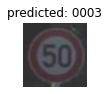

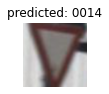

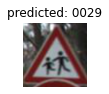

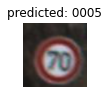

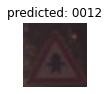

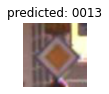

--------Experiment for constant lr:0.01 ends!------------
----------Experiment for constant lr:0.001 starts!-----------
Epoch 0/9
----------
train Loss: 2.8217 Acc: 0.2978
val Loss: 2.1512 Acc: 0.4505

Epoch 1/9
----------
train Loss: 2.1993 Acc: 0.4285
val Loss: 1.7550 Acc: 0.5441

Epoch 2/9
----------
train Loss: 1.9636 Acc: 0.4771
val Loss: 1.5556 Acc: 0.5789

Epoch 3/9
----------
train Loss: 1.8198 Acc: 0.5080
val Loss: 1.4275 Acc: 0.6139

Epoch 4/9
----------
train Loss: 1.7283 Acc: 0.5254
val Loss: 1.3421 Acc: 0.6327

Epoch 5/9
----------
train Loss: 1.6538 Acc: 0.5410
val Loss: 1.2669 Acc: 0.6390

Epoch 6/9
----------
train Loss: 1.6172 Acc: 0.5473
val Loss: 1.2273 Acc: 0.6558

Epoch 7/9
----------
train Loss: 1.5647 Acc: 0.5594
val Loss: 1.1880 Acc: 0.6656

Epoch 8/9
----------
train Loss: 1.5323 Acc: 0.5720
val Loss: 1.1462 Acc: 0.6769

Epoch 9/9
----------
train Loss: 1.5021 Acc: 0.5765
val Loss: 1.1227 Acc: 0.6813

Training complete in 22m 16s
Best val Acc: 0.681331


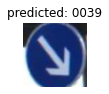

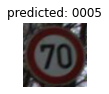

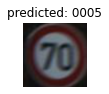

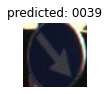

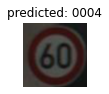

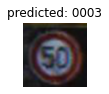

--------Experiment for constant lr:0.001 ends!------------


In [ ]:
lr_list = [1, 0.1, 0.01, 0.001]

for lr in lr_list:
  print(f'----------Experiment for constant lr:{lr} starts!-----------')
  model_conv = torchvision.models.resnet50(pretrained=True)
  for param in model_conv.parameters():
      param.requires_grad = False

  # Parameters of newly constructed modules have requires_grad=True by default
  num_ftrs = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_ftrs, len(class_names) )

  model_conv = model_conv.to(device)
  criterion = nn.CrossEntropyLoss()
  # Observe that only parameters of final layer are being optimized as
  # opposed to before.
  optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=lr, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=1)
  model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)
  visualize_model(model_conv)
  plt.ioff()
  plt.show()
  print(f'--------Experiment for constant lr:{lr} ends!------------')

(b) For your target dataset find the best final accuracy (across all the learning rates) from the two transfer learning approaches. Which approach and learning rate is the winner? Provide a plausible explanation to support your observation. 

Observation:

|transfer learning approach|Learning Rate|Best Validation Accuracy|
|--------------- |--------------- |--------------- |
|finetune|0.001 exponential decay|0.988906|
|**finetune**|**0.01 constant**|**0.996940**|
|finetune|0.1 constant|0.975644|
|feature extraction|1 constant|0.683499|
|feature extraction|0.1 constant|0.655828|
|feature extraction|0.01 constant|0.751466|
|feature extraction|0.001 constant|0.681331|

Finetune with constant learning rate = 0.01 is the winner among all tested combinations. The 0.01 learning rate is neither too small(model learns slowly) nor too large(not converge). Finetuning performs better than using the pretrained model(jointly tuning parameters in all layers) as a feature extractor(all layers of the network are frozen except for the last layer) because it is less regid and more flexible compared with feature extraction. It can adapts parameters in pretrained layers to better fit the new dataset. 


## Problem 4 - Weakly and Semi-Supervised Learning for Image Classification 20 points
This problem is based on two papers, by Mahajan et al. on weakly supervised pretraining and by Yalinz et al. on semi-supervised learning for image classification. Both of these papers are from Facebook and used 1B images wiith hashtags. Read the two papers thoroughly and then answer the following questions. You can discuss these papers with your classmates if this helps in clarifying your doubts and improving your understanding. However no sharing of answers is permitted and all the questions should be answered individually in your own words.


1. Both the papers use the same 1B image dataset. However one does weakly supervised pretraining while the other does semi-supervised . What is the difference between weakly supervised and semi-supervised pretraining ? How do they use the same dataset to do two different types of pretraining ? Explain.


Both semi-supervisiion and weakly supervision alleviates the burden of obtaining manully-labeled data. Semi-supervised learning aims to label unlabeld data using knowledge from a small number of labeled data. These labeled data might be outputs of a teacher model trained on other labeled datasets. Weakly supervision exploits noisy, or imprecise data in the wild other than the target dataset. provide them with supervision signal for labeleing large amounts of training data. 

Mahajan experimented with weakly supervision. He finetuned the 1B image dataset on a large-scale pretrained model predicting hashtags on billions of instagram images. The model inferences based on knowledge learned from the pretaining task. In comparison, Yalinz experimented with semi-spervised learning on the task of classifying the 1B image dataset. He proposes a teacher/student paradigm that leverages a large collection of unlabled images. The student model learns from an unlabeled target dataset under the supervision of a teacher model. 

2. These questions are based on the paper by Mahajan et al.

(a) Are the model trained using hashtags robust against noise in the labels ? What experiments were done in the paper to study this and what was the finding ? Provide numbers from the paper to support your answer.

The model trained using hashtags are robust against noise in the labels. 


Experiments:

Mahajan investigates the effect of injecting additional label noise on the accuracy of our networks. Researchers pretrain ResNeXt-101 32×16d networks on a version of IG-1B-17k in which they randomly replaced p% of the hashtags by hashtags obtained by sampling from the marginal distribution over hashtags. They only train the final linear classifier on the target task, because full finetuning may mask the damage caused by pretraining noise.

Findings: label noise may be a limited issue if networks are trained on billions of images. A noise level of p = 10% leads to a loss of less than 1% in classification accuracy, and at p=25% label noise, the reduction in accuracy is around 2%.


(b) Why is resampling of hashtag distribution important during pretraining for transfer learning ?

The hashtag follows a Zipfian distribution different from that of the ImageNet. The result of the model on target set is maximized if the difference in distribution is adjusted. Prior studies in language modeling found that resampling Zipfian distributions reduces the impact of the head of the word distribution on the overall training loss. 

The results show that resampling of the hashtag distribution is important in order to obtain good transfer to ImageNet image-classification tasks: using uniform or square-root sampling leads to an accuracy improvement of 5 to 6% irrespective of the number of ImageNet classes in the transfer task.

3. These questions are based on the paper by Yalzin et al.

(a) Why are there two models, a teacher and a student, and how does the student model leverages the teacher model ? Explain why teacher-student modeling is a type of distillation technique.

The student model leverages the teacher model by the following stages:
1. Train a teacher model on labeled data $D$
2. Run the trained model on unlabeled data $U$ and select relevant examples for each label to construct a new labeled dataset $\hat{D}$
3.  Train a new student model on $\hat{D}$
4.  Fine-tune the trained student on the labeled set $D$.

The teacher model trained on available labeled datset infers labels for the unlabled target datasets so that the student model can utilize those newly labeled data for classification in a supervised fashion. 

The teacher-student modeling is a type of distillation technique, which was originally introduced to compress a large model(teacher) into a smaller and faster(student) one. In the case of self-training, the teacher model makes predictions on unlabelled data, and the inferred labels are used to train the student in a supervised fashion. The student model is a compression of the teacher model and reproduces at best the output of the teacher. 

(b) What are the parameters K and P in stage 2 of the approach where unlabeled images are assigned classes using teacher network ? What was the idea behind taking P > 1 ? Explain in your own words. 

The large-scale unlabeled dataset may contain lots of images from classes that do not exist in the target dataset, adding noise to the training. To obtain large number of images while limiting labelling noise, researchers propose to select top K examples from the target unlabled dataset $U$ for each label. When the teacher model inferences on each example in $U$, it generates scores for each class. Researchers can choose the value of P, which is the number of most likely classes they intend to keep, to limit the number of relevant classes to occur in each image. 

Setting $P>1$ is a way to collect enough reliable examples for the tail classes when the collection $U$ is not large enough. Researchers choose $P>1$ because it is difficult to identify accurately under-represented or co-occuring concepts, and it is safer to keep more relevant classes. Setting P=1 may leave out the true label when an image has multiple relevant concepts.

(c) Explain how a new labeled dataset is created using unlabeled images ? Can an image in this new dataset belong to more than one class ? Explain.

The pretrained teacher model run inferences on each example in the unlabeled class $U$ and keep top P most likely classes for the example as inferred labels. Copies of example are made for each label. Then all images are sorted by their labels. Pick top K images of each label to form the new labeled dataset. 

An image in this new dataset can belong to multiple classes because we select $P>1$ and it is likely that several copies of the same image are all among the top K in confidence within repective label classes.

(d) Refer to Figure 5 in the paper. Why does the accuracy of the student model first improves as we increase the value of K and then decreases ?

When K is very small, the accuracy of the student model is low because thet sample size of the labeled dataset is too small for the model to learn patterns in a supervised fashion and generalize to unseen data. As K increases, more samples from each classes in $U$ is included in the training data for the student model, but the quality of data decreases as more and more images with lower confidence scores are also included. When K is too large, the student model is confused by mistakes(too many images with lower confidence scores in label) in the training dataset. The student model's accuracy is optimal when K is neither too small nor too large. 